In [1]:
# ============================================================================
# CELL 0 : SETUP - PHASE 3C (ONLINE TRAINING - REVISED)
# ============================================================================

import os
import sys
from pathlib import Path

os.chdir('/workspaces/energy-rl-project')
sys.path.insert(0, '/workspaces/energy-rl-project/src')

os.environ['EPLUS_PATH'] = '/usr/local/EnergyPlus-24-2-0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import shutil

from src.config import DATA_RAW_DIR, RESULTS_LOGS_DIR, RESULTS_FIGURES_DIR
from src.environments import BuildingBatteryEnv
from src.algorithms.sac import SAC, ReplayBuffer as SACReplayBuffer
from src.algorithms.td3 import TD3, ReplayBuffer as TD3ReplayBuffer

print("✅ Setup Phase 3C (REVISED) terminé")
print(f"   Device: {'GPU (CUDA)' if torch.cuda.is_available() else 'CPU'}")
print(f"   SAC: Action bounds correctly applied (tanh + scaling)")
print(f"   TD3: Action bounds correctly applied (tanh + scaling)")

Couldn't import dot_parser, loading of dot files will not be possible.
[CONFIG] Sinergym logs directory: /workspaces/energy-rl-project/data/raw
✅ Setup Phase 3C (REVISED) terminé
   Device: CPU
   SAC: Action bounds correctly applied (tanh + scaling)
   TD3: Action bounds correctly applied (tanh + scaling)


In [2]:
# ============================================================================
# CELL 1 : FONCTION HELPER POUR ONLINE TRAINING
# ============================================================================

def train_agent_online(agent_name, agent, num_episodes, buildings_list=None, max_steps=250):
    """
    Train an agent online with the simulator.
    
    Args:
        agent_name: 'SAC' or 'TD3'
        agent: Agent instance
        num_episodes: Number of episodes to train
        buildings_list: List of building IDs to alternate
        max_steps: Max steps per episode
    
    Returns:
        Dictionary with training history
    """
    
    if buildings_list is None:
        buildings_list = [
            'Eplus-5zone-hot-continuous-v1',
            'Eplus-5zone-cool-continuous-v1',
            'Eplus-5zone-mixed-continuous-v1',
        ]
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    history = {
        'episode': [],
        'total_reward': [],
        'episode_length': [],
        'losses': [],
        'avg_soc': [],  # ⭐ New: track battery SOC
        'avg_cost': []  # ⭐ New: track electricity cost
    }
    
    log_file = RESULTS_LOGS_DIR / f'phase_3c_{agent_name.lower()}_training.log'
    with open(log_file, 'w') as f:
        f.write(f"Phase 3C : {agent_name} Online Training\n")
        f.write(f"Start: {datetime.now()}\n")
        f.write(f"Buildings: {buildings_list}\n")
        f.write("=" * 80 + "\n\n")
    
    print(f"\n{'=' * 80}")
    print(f"🎓 {agent_name} ONLINE TRAINING ({num_episodes} episodes)")
    print(f"{'=' * 80}")
    print(f"Buildings to alternate: {[b.split('-')[1] for b in buildings_list]}\n")
    
    # Créer replay buffer selon l'agent
    if agent_name == 'SAC':
        replay_buffer = SACReplayBuffer(max_size=1e6)
    else:  # TD3
        replay_buffer = TD3ReplayBuffer(max_size=1e6)
    
    # ⭐ NOISE DECAY pour TD3/exploration progressive
    noise_decay = 0.99  # Decay noise chaque episode
    
    # Boucle sur les episodes
    for ep_num in range(num_episodes):
        building_id = buildings_list[ep_num % len(buildings_list)]  # ⭐ Alterner buildings
        
        try:
            # Créer nouvel env
            base_env = gym.make(building_id)
            wrapped_env = BuildingBatteryEnv(
                env=base_env,
                battery_capacity=10.0,
                battery_efficiency=0.9,
                battery_power_max=5.0,
                soc_min=0.2,
                soc_max=0.9,
                pv_max_power=5.0,
                pv_efficiency=0.2,
                price_on_peak=0.25,
                price_off_peak=0.10,
                comfort_temp_range=(21.0, 25.0),
                lambda_comfort=1.0,
                lambda_battery=0.1
            )
        except Exception as e:
            print(f"Episode {ep_num + 1}: ❌ Env creation failed: {e}")
            continue
        
        # Reset
        try:
            obs, _ = wrapped_env.reset()
        except Exception as e:
            print(f"Episode {ep_num + 1}: ❌ Reset failed: {e}")
            wrapped_env.close()
            base_env.close()
            continue
        
        # Episode loop
        total_reward = 0
        episode_losses = []
        soc_trajectory = []
        cost_trajectory = []
        
        for step in range(max_steps):
            try:
                # Agent chooses action
                action = agent.select_action(obs, deterministic=False)
                
                # ⭐ VÉRIFIER QUE L'ACTION EST VALIDE
                if not wrapped_env.action_space.contains(action):
                    print(f"   ⚠️ Invalid action at step {step}: {action} → resampling")
                    action = wrapped_env.action_space.sample()
                
                # Environment step
                next_obs, reward, terminated, truncated, info = wrapped_env.step(action)
                done = terminated or truncated
                
                # Store in replay buffer
                replay_buffer.add(obs, action, reward, next_obs, done)
                
                # Train step
                if len(replay_buffer) > 256:
                    loss_dict = agent.train_step(replay_buffer, batch_size=64)
                    if loss_dict:
                        episode_losses.append(loss_dict)
                
                total_reward += reward
                soc_trajectory.append(info.get('soc', 0.5))
                cost_trajectory.append(info.get('electricity_cost', 0.0))
                
                obs = next_obs
                
                if done:
                    break
            
            except Exception as e:
                print(f"   ⚠️ Step {step}: {str(e)[:50]}")
                break
        
        # ⭐ CLEANUP AMÉLIORÉ
        eplus_dirs = list(Path('/workspaces/energy-rl-project').glob('Eplus-*-res*'))
        for dir_path in eplus_dirs:
            try:
                shutil.rmtree(str(dir_path))  # Supprimer complètement
            except:
                pass
        
        wrapped_env.close()
        base_env.close()
        
        # Log
        building_short = building_id.split('-')[1]
        avg_soc = np.mean(soc_trajectory) if soc_trajectory else 0.5
        avg_cost = np.mean(cost_trajectory) if cost_trajectory else 0.0
        avg_loss = np.mean([list(l.values())[0] for l in episode_losses]) if episode_losses else 0.0
        
        history['episode'].append(ep_num)
        history['total_reward'].append(total_reward)
        history['episode_length'].append(step)
        history['losses'].append(avg_loss)
        history['avg_soc'].append(avg_soc)
        history['avg_cost'].append(avg_cost)
        
        # Print progress
        if (ep_num + 1) % 20 == 0:
            avg_reward_20 = np.mean(history['total_reward'][-20:])
            print(f"Episode {ep_num + 1:3d}/{num_episodes} ({building_short:5s}) - "
                  f"Reward: {total_reward:8.2f} | Avg20: {avg_reward_20:8.2f} | "
                  f"SOC: {avg_soc:.2f} | Cost: ${avg_cost:.2f}")
        
        # Log to file
        with open(log_file, 'a') as f:
            f.write(f"Episode {ep_num + 1} ({building_short}): "
                   f"Reward={total_reward:.2f}, SOC={avg_soc:.2f}, Cost=${avg_cost:.2f}\n")
    
    with open(log_file, 'a') as f:
        f.write(f"\nEnd: {datetime.now()}\n")
    
    return history

print("✅ Helper function ready")

✅ Helper function ready


In [4]:
# ============================================================================
# CELL 2 : CRÉER AGENTS SAC ET TD3
# ============================================================================

print("\n" + "=" * 80)
print("🔧 CREATING AGENTS (SAC + TD3)")
print("=" * 80)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Créer env de base juste pour obtenir les dimensions
try:
    base_env = gym.make('Eplus-5zone-hot-continuous-v1')
    wrapped_env = BuildingBatteryEnv(
        env=base_env,
        battery_capacity=10.0,
        battery_efficiency=0.9,
        battery_power_max=5.0,
        soc_min=0.2,
        soc_max=0.9,
        pv_max_power=5.0,
        pv_efficiency=0.2,
        price_on_peak=0.25,
        price_off_peak=0.10,
        comfort_temp_range=(21.0, 25.0),
        lambda_comfort=1.0,
        lambda_battery=0.1
    )
    obs, _ = wrapped_env.reset()
    state_dim = obs.shape[0]
    action_dim = wrapped_env.action_space.shape[0]
    wrapped_env.close()
    base_env.close()
    
    print(f"\n📊 Dimensions:")
    print(f"   State dim: {state_dim}")
    print(f"   Action dim: {action_dim}")
except Exception as e:
    print(f"❌ Error: {e}")
    sys.exit(1)

# Créer SAC
print(f"\n✅ Creating SAC agent...")
sac_agent = SAC(
    state_dim=state_dim,
    action_dim=action_dim,
    hidden_dim=256,
    learning_rate=3e-4,
    gamma=0.99,
    tau=0.005,
    alpha=0.5,
    device=device
)
print(f"   Action bounds: [12-23.25, 23.25-30, -1 to 1]")
print(f"   Network: Actor + Dual Critic (Q1, Q2)")

# Créer TD3
print(f"\n✅ Creating TD3 agent...")
td3_agent = TD3(
    state_dim=state_dim,
    action_dim=action_dim,
    hidden_dim=256,
    learning_rate=3e-4,
    gamma=0.99,
    tau=0.005,
    policy_delay=2,
    noise_std=0.4,
    device=device,
    action_low=np.array([12., 23.25, -1.]),
    action_high=np.array([23.25, 30., 1.])
)
print(f"   Action bounds: [12-23.25, 23.25-30, -1 to 1]")
print(f"   Network: Actor + Dual Critic (Q1, Q2)")

print(f"\n✅ Agents created successfully (device: {device})")


🔧 CREATING AGENTS (SAC + TD3)
#==============================================================================================#  
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1                           
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res2
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (INFO) : timestep size (seconds): 900.0              

In [5]:
# CELL 3 : TEST 1 ÉPISODE (VÉRIFICATION ACTION BOUNDS)
# ============================================================================

print("\n" + "=" * 80)
print("🧪 TEST 1 ÉPISODE : Vérification action bounds et execution")
print("=" * 80)

# ⭐ CHOISIR L'AGENT À TESTER
AGENT_TO_TEST = 'TD3'  # Change en 'TD3' pour tester TD3

agent_to_test = sac_agent if AGENT_TO_TEST == 'SAC' else td3_agent

print(f"\nTesting with {AGENT_TO_TEST}...\n")

try:
    # ⭐ CRÉER ENV DE TEST
    base_env = gym.make('Eplus-5zone-hot-continuous-v1')
    wrapped_env = BuildingBatteryEnv(
        env=base_env,
        battery_capacity=10.0,
        battery_efficiency=0.9,
        battery_power_max=5.0,
        soc_min=0.2,
        soc_max=0.9,
        pv_max_power=5.0,
        pv_efficiency=0.2,
        price_on_peak=0.25,
        price_off_peak=0.10,
        comfort_temp_range=(21.0, 25.0),
        lambda_comfort=1.0,
        lambda_battery=0.1
    )
except Exception as e:
    print(f"❌ Erreur création env: {e}")
    raise

# ⭐ RESET
print("Reset environnement...")
try:
    obs, info = wrapped_env.reset()
    print(f"✅ Reset OK - Observation shape: {obs.shape}\n")
except Exception as e:
    print(f"❌ Erreur reset: {e}")
    wrapped_env.close()
    base_env.close()
    raise

# ⭐ LOOP TEST : 250 STEPS MAX
total_reward = 0
step_count = 0
done = False
invalid_action_count = 0

print(f"Début épisode de test ({AGENT_TO_TEST}) - max 250 steps...\n")

while not done and step_count < 250:
    try:
        # Sélection d'action (deterministic=False = avec exploration)
        action = agent_to_test.select_action(obs, deterministic=False)
        
        # ⭐ VÉRIFICATION ACTION BOUNDS (crucial !)
        if not wrapped_env.action_space.contains(action):
            print(f"Step {step_count}: ⚠️ Invalid action {action} → resampling")
            action = wrapped_env.action_space.sample()
            invalid_action_count += 1
        
        # Step dans l'environnement
        next_obs, reward, terminated, truncated, info = wrapped_env.step(action)
        done = terminated or truncated
        
        total_reward += reward
        obs = next_obs
        step_count += 1
        
        # Print tous les 50 steps
        if step_count % 50 == 0:
            print(f"  Step {step_count:3d} - Reward: {reward:8.4f} - Total: {total_reward:8.2f} - SOC: {info.get('soc', 0.5):.2f}")
        
    except Exception as e:
        print(f"Step {step_count}: ❌ Erreur: {e}")
        break

# ⭐ CLEANUP
print(f"\n🧹 Cleaning up Eplus directories...")
eplus_dirs = list(Path('/workspaces/energy-rl-project').glob('Eplus-*-res*'))
for dir_path in eplus_dirs:
    try:
        shutil.rmtree(str(dir_path))
    except:
        pass

wrapped_env.close()
base_env.close()

# ⭐ RÉSUMÉ
print("\n" + "=" * 80)
print(f"✅ TEST TERMINÉ")
print("=" * 80)
print(f"Agent: {AGENT_TO_TEST}")
print(f"Steps completed: {step_count}/250")
print(f"Total reward: {total_reward:.2f}")
print(f"Invalid actions: {invalid_action_count} (should be 0)")
if invalid_action_count == 0:
    print(f"✅ EXCELLENT - Actions are properly bounded!")
else:
    print(f"⚠️ Action bounds need adjustment")
print("=" * 80)


🧪 TEST 1 ÉPISODE : Vérification action bounds et execution

Testing with TD3...

#==============================================================================================#   
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.                               
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1                           
#==============================================================================================# 
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res3
[MODEL] (INFO) : Model Config is correct.                                            
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names. 
[MODEL] (INFO) : Updated building model Output:Meter with meter names.               
[MODEL] (INFO) : Runperiod established.                                              
[MODEL] (INFO) : Episode length (seconds): 31536000.0                                
[MODEL] (

Program terminated: EnergyPlus Terminated--Error(s) Detected.


In [6]:
# ============================================================================
# CELL 4 : ENTRAÎNER SAC (100 EPISODES)
# ============================================================================

# ⭐ CONFIGURATION
NUM_EPISODES_SAC = 350
BUILDINGS_FOR_SAC = [
    'Eplus-5zone-hot-continuous-v1',
    'Eplus-5zone-cool-continuous-v1',
    'Eplus-5zone-mixed-continuous-v1',
]

print(f"\n" + "=" * 80)
print(f"🎓 PHASE 3C : SAC ONLINE TRAINING")
print("=" * 80)
print(f"Episodes: {NUM_EPISODES_SAC}")
print(f"Buildings: {[b.split('-')[1] for b in BUILDINGS_FOR_SAC]}")
print(f"Estimated time: 30-45 minutes on CPU")
print(f"Device: {device}")
print("=" * 80 + "\n")

# ⭐ ENTRAÎNER
sac_history = train_agent_online(
    agent_name='SAC',
    agent=sac_agent,
    num_episodes=NUM_EPISODES_SAC,
    buildings_list=BUILDINGS_FOR_SAC,
    max_steps=250
)

print(f"\n" + "=" * 80)
print(f"✅ SAC TRAINING COMPLETED")
print("=" * 80)

# ⭐ STATS
avg_reward = np.mean(sac_history['total_reward'])
max_reward = np.max(sac_history['total_reward'])
min_reward = np.min(sac_history['total_reward'])
avg_cost = np.mean(sac_history['avg_cost'])
avg_soc = np.mean(sac_history['avg_soc'])

print(f"Reward stats:")
print(f"  Average: {avg_reward:.2f}")
print(f"  Max:     {max_reward:.2f}")
print(f"  Min:     {min_reward:.2f}")
print(f"  Avg SOC: {avg_soc:.2f}")
print(f"  Avg Cost: ${avg_cost:.2f}")
print("=" * 80)

# ⭐ SAUVEGARDER
sac_checkpoint = RESULTS_FIGURES_DIR.parent / 'checkpoints' / 'sac_agent.pt'
print(f"\n💾 Saving SAC checkpoint...")
sac_agent.save(str(sac_checkpoint))
print(f"✅ Saved: {sac_checkpoint}")


🎓 PHASE 3C : SAC ONLINE TRAINING
Episodes: 350
Buildings: ['5zone', '5zone', '5zone']
Estimated time: 30-45 minutes on CPU
Device: cpu


🎓 SAC ONLINE TRAINING (350 episodes)
Buildings to alternate: ['5zone', '5zone', '5zone']

#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:33,  1.05%/s, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:06<04:59,  3.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:18,  1.41s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:39,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.03s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:30,  1.09%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:36,  1.02%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:41,  1.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:33,  1.05%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode  20/350 (5zone) - Reward:   -54.75 | Avg20:   -68.60 | SOC: 0.52 | Cost: $0.21
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:17,  1.40s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:30,  1.08%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:33,  1.05%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:41,  1.03s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:39,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:30,  1.08%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:31,  1.07%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:41,  1.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:37,  1.01%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.04%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:41,  1.03s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:42,  1.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode  40/350 (5zone) - Reward:   -46.31 | Avg20:   -71.40 | SOC: 0.52 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#=======================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.04%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:38,  1.00s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:32,  1.06%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.04%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:37,  1.01%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:39,  1.01s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:37,  1.01%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENV

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:39,  1.01s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.07s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environme

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:41,  1.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:08,  1.31s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:42,  1.05s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT]

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.07s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:41,  1.03s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode  80/350 (5zone) - Reward:   -54.75 | Avg20:   -68.60 | SOC: 0.52 | Cost: $0.21
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:17,  1.40s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.07s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:41,  1.03s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:42,  1.05s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 100/350 (5zone) - Reward:   -46.31 | Avg20:   -71.40 | SOC: 0.52 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#=======================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:10,  1.33s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:15,  1.39s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 120/350 (5zone) - Reward:  -110.75 | Avg20:   -71.82 | SOC: 0.52 | Cost: $0.37
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#=======

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.07s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:07,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zo

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 140/350 (5zone) - Reward:   -54.75 | Avg20:   -68.60 | SOC: 0.52 | Cost: $0.21
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:15,  1.38s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continu

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 160/350 (5zone) - Reward:   -46.31 | Avg20:   -71.40 | SOC: 0.52 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#=======================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:06,  1.29s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:10,  1.33s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:07,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 180/350 (5zone) - Reward:  -110.75 | Avg20:   -71.82 | SOC: 0.52 | Cost: $0.37
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#=======

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:38,  1.62s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:13,  1.36s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]


Program terminated: EnergyPlus Terminated--Error(s) Detected.


#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#--------------------------------------------------------------------------------------------

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 200/350 (5zone) - Reward:   -54.75 | Avg20:   -68.60 | SOC: 0.52 | Cost: $0.21
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:19,  1.42s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:09,  1.32s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:09,  1.32s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 220/350 (5zone) - Reward:   -46.31 | Avg20:   -71.40 | SOC: 0.52 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#=======================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:34,  1.58s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:13,  1.36s/%, 2% completed]   
[ENVIRONMENT] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:09,  1.32s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:10,  1.33s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:09,  1.32s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:34,  1.57s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 240/350 (5zone) - Reward:  -110.75 | Avg20:   -71.82 | SOC: 0.52 | Cost: $0.37
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#=======

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:12,  1.35s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:13,  1.37s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:08,  1.31s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:12,  1.35s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 260/350 (5zone) - Reward:   -54.75 | Avg20:   -68.60 | SOC: 0.52 | Cost: $0.21
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:21,  1.44s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:07,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-m

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:25,  1.48s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 280/350 (5zone) - Reward:   -46.31 | Avg20:   -71.40 | SOC: 0.52 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#========================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-m

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:07,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:15,  1.38s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:17,  1.41s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:10,  1.33s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 300/350 (5zone) - Reward:  -110.75 | Avg20:   -71.82 | SOC: 0.52 | Cost: $0.37
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:38,  1.62s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:06,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:11,  1.35s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:07,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-m

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:07,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:24,  1.48s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:06,  1.29s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#===================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<03:15,  1.99s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continu

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:15,  1.38s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 320/350 (5zone) - Reward:   -54.75 | Avg20:   -68.60 | SOC: 0.52 | Cost: $0.21
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspac

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:28,  1.52s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:12,  1.35s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:09,  1.32s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:09,  1.32s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:05,  1.28s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:37,  1.60s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:12,  1.35s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 340/350 (5zone) - Reward:   -46.31 | Avg20:   -71.40 | SOC: 0.52 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#=======================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:18,  1.41s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]


Program terminated: EnergyPlus Terminated--Error(s) Detected.



✅ SAC TRAINING COMPLETED
Reward stats:
  Average: -70.49
  Max:     -46.31
  Min:     -110.75
  Avg SOC: 0.52
  Avg Cost: $0.26

💾 Saving SAC checkpoint...
✅ Saved: /workspaces/energy-rl-project/results/checkpoints/sac_agent.pt


In [7]:
# ============================================================================
# CELL 5 : ENTRAÎNER TD3 (100 EPISODES)
# ============================================================================

# ⭐ CONFIGURATION (même buildings que SAC pour comparaison équitable)
NUM_EPISODES_TD3 = 350
BUILDINGS_FOR_TD3 = [
    'Eplus-5zone-hot-continuous-v1',
    'Eplus-5zone-cool-continuous-v1',
    'Eplus-5zone-mixed-continuous-v1',
]

print(f"\n" + "=" * 80)
print(f"🎓 PHASE 3C : TD3 ONLINE TRAINING")
print("=" * 80)
print(f"Episodes: {NUM_EPISODES_TD3}")
print(f"Buildings: {[b.split('-')[1] for b in BUILDINGS_FOR_TD3]}")
print(f"Estimated time: 30-45 minutes on CPU")
print(f"Device: {device}")
print("=" * 80 + "\n")

# ⭐ ENTRAÎNER
td3_history = train_agent_online(
    agent_name='TD3',
    agent=td3_agent,
    num_episodes=NUM_EPISODES_TD3,
    buildings_list=BUILDINGS_FOR_TD3,
    max_steps=250
)

print(f"\n" + "=" * 80)
print(f"✅ TD3 TRAINING COMPLETED")
print("=" * 80)

# ⭐ STATS
avg_reward = np.mean(td3_history['total_reward'])
max_reward = np.max(td3_history['total_reward'])
min_reward = np.min(td3_history['total_reward'])
avg_cost = np.mean(td3_history['avg_cost'])
avg_soc = np.mean(td3_history['avg_soc'])

print(f"Reward stats:")
print(f"  Average: {avg_reward:.2f}")
print(f"  Max:     {max_reward:.2f}")
print(f"  Min:     {min_reward:.2f}")
print(f"  Avg SOC: {avg_soc:.2f}")
print(f"  Avg Cost: ${avg_cost:.2f}")
print("=" * 80)

# ⭐ SAUVEGARDER
td3_checkpoint = RESULTS_FIGURES_DIR.parent / 'checkpoints' / 'td3_agent.pt'
print(f"\n💾 Saving TD3 checkpoint...")
td3_agent.save(str(td3_checkpoint))
print(f"✅ Saved: {td3_checkpoint}")


🎓 PHASE 3C : TD3 ONLINE TRAINING
Episodes: 350
Buildings: ['5zone', '5zone', '5zone']
Estimated time: 30-45 minutes on CPU
Device: cpu


🎓 TD3 ONLINE TRAINING (350 episodes)
Buildings to alternate: ['5zone', '5zone', '5zone']

#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:04,  1.51%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:06,  1.46%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:04,  1.52%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:04,  1.51%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:05,  1.50%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:13,  1.34%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:04,  1.51%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:13,  1.34%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:07,  1.46%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:04,  1.52%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:20,  1.21%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:07,  1.45%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:14,  1.32%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:16,  1.28%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:08,  1.44%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:21,  1.21%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:06,  1.48%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:08,  1.43%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode  20/350 (5zone) - Reward:   -51.68 | Avg20:   -65.88 | SOC: 0.48 | Cost: $0.20
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:04,  1.52%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:14,  1.31%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:15,  1.29%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:05,  1.49%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:06,  1.48%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:15,  1.30%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:17,  1.27%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:24,  1.16%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:21,  1.21%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initializ

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:11,  1.36%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:17,  1.27%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:42,  1.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:15,  1.29%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:27,  1.11%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:15,  1.30%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:13,  1.34%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:16,  1.28%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode  40/350 (5zone) - Reward:   -44.48 | Avg20:   -68.83 | SOC: 0.48 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:22,  1.18%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:13,  1.33%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:25,  1.15%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<00:59,  1.65%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:24,  1.16%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:17,  1.27%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:26,  1.13%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:23,  1.17%/s, 2% completed]   


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:14,  1.31%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:19,  1.24%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:41,  1.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:27,  1.11%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#------------------------------------

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:15,  1.30%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:17,  1.27%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:13,  1.33%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:05<04:30,  2.76s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:13,  1.36s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:33,  1.05%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:35,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:22,  1.18%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:13,  1.37s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:26,  1.13%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continu

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:26,  1.13%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:36,  1.02%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:26,  1.14%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:11,  1.37%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:30,  1.09%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode  80/350 (5zone) - Reward:   -51.63 | Avg20:   -65.87 | SOC: 0.48 | Cost: $0.20
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspac

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:35,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:36,  1.02%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.03s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:24,  1.48s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:58,  1.82s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:04<03:19,  2.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#===================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:18,  1.41s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:11<09:16,  5.67s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#---------------

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:11<09:12,  5.64s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continu

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:05<04:30,  2.76s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:56,  1.80s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:16<13:49,  8.47s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.03s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 100/350 (5zone) - Reward:   -44.48 | Avg20:   -67.49 | SOC: 0.48 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#=======================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:28,  1.51s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:30,  1.53s/%, 2% completed]  


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initializ

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:38,  1.01s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:37,  1.01%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:12,  1.35s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:37,  1.00%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:05<04:45,  2.92s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is c

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:23,  1.46s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.07s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 120/350 (5zone) - Reward:  -107.21 | Avg20:   -69.12 | SOC: 0.48 | Cost: $0.36
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:39,  1.01s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:37,  1.01%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVI

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:33,  1.05%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:32,  1.06%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:31,  1.07%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:42,  1.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.04%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.03s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT]

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:35,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:31,  1.07%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 140/350 (5zone) - Reward:   -52.13 | Avg20:   -65.97 | SOC: 0.48 | Cost: $0.20
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:42,  1.05s/%, 2% completed]   


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initializ

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:30,  1.08%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:42,  1.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:38,  1.01s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:29,  1.10%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:36,  1.02%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:35,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#===================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:29,  1.10%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:29,  1.09%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:29,  1.09%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.07s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:30,  1.08%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 160/350 (5zone) - Reward:   -44.67 | Avg20:   -68.87 | SOC: 0.48 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#=======================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:36,  1.02%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:34,  1.57s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:38,  1.00s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:36,  1.02%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:33,  1.05%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continu

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:15,  1.39s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:37,  1.61s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:38,  1.01s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 180/350 (5zone) - Reward:  -107.93 | Avg20:   -69.08 | SOC: 0.48 | Cost: $0.36
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:38,  1.00s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:45,  1.69s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: E

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.19s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:07,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:21,  1.44s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.03%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:15,  1.39s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[EN

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:04,  1.27s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:01,  1.24s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:37,  1.00%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 200/350 (5zone) - Reward:   -51.87 |

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:42,  1.05s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:34,  1.04%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.22s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:27,  1.50s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:55,  1.79s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-r

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:29,  1.52s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /worksp

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-r

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:59,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==========================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:40,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:04<03:43,  2.28s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuo

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 220/350 (5zone) - Reward:   -44.09 | Avg20:   -68.60 | SOC: 0.48 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MOD

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:26,  1.13%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#---------------------------------------------------------------------------------------------

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<03:01,  1.85s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5z

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:37,  1.00%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:03,  1.26s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#===========================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:11,  1.34s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#====================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:29,  1.52s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:09,  1.32s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#===================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:25,  1.49s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:14,  1.38s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:56,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:19,  1.42s/%, 2% completed]   


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:07,  1.30s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:21,  1.44s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<03:14,  1.98s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 260/350 (5zone) - Reward:   -52.17 | Avg20:   -65.94 | SOC: 0.48 | Cost: $0.20
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: E

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:05<04:19,  2.65s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:23,  1.47s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:04<03:33,  2.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continu

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:09,  1.32s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:04<03:25,  2.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<03:03,  1.87s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:21,  1.44s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================#


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1


Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRO

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: E

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVI

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:21,  1.44s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENV

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:24,  1.47s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:43,  1.06s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:45,  1.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
Episode 300/350 (5zone) - Reward:  -107.38 | Avg20:   -67.44 | SOC: 0.48 | Cost: $0.36
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.11s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:55,  1.18s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:10,  1.33s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continu

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:46,  1.09s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.17s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:44,  1.07s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continu

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:48,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:03<02:32,  1.56s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.14s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:53,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
Episode 320/350 (5zone) - Reward:   -52.42 | Avg20:   -65.84 | SOC: 0.48 | Cost: $0.20
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] 

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:12,  1.36s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:01<01:31,  1.07%/s, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:00,  1.23s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:04<03:19,  2.04s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:39,  1.02s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:02,  1.25s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:06<04:59,  3.05s/%, 2% completed]  
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) :

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:04<03:51,  2.36s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:51,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#=======================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INF

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:54,  1.16s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-mixed-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:49,  1.12s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:47,  1.10s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
Episode 340/350 (5zone) - Reward:   -44.55 | Avg20:   -67.13 | SOC: 0.48 | Cost: $0.18
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#=======================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:58,  1.21s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:08,  1.31s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:52,  1.15s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:57,  1.20s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-hot-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-cool-continuous-v1
#==============================================================================================#
[MODEL] (INFO)

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<02:17,  1.40s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-mixed-continuous-v1
#===================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Weather file USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-mixed-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:04<03:23,  2.08s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-mixed-continuous-v1]
#==============================================================================================#
[ENVIRONMENT] (INFO) : Creating Gymnasium environment.
[ENVIRONMENT] (INFO) : Name: Eplus-5zone-hot-continuous-v1
#==============================================================================================

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[MODEL] (INFO) : Working directory created: /workspaces/energy-rl-project/Eplus-5zone-hot-continuous-v1-res1
[MODEL] (INFO) : Model Config is correct.
[MODEL] (INFO) : Building model Output:Variable updated with defined variable names.
[MODEL] (INFO) : Updated building model Output:Meter with meter names.
[MODEL] (INFO) : Runperiod established.
[MODEL] (INFO) : Episode length (seconds): 31536000.0
[MODEL] (INFO) : timestep size (seconds): 900.0
[MODEL] (INFO) : timesteps per episode: 35040
[REWARD] (INFO) : Reward function initialized.
[ENVIRONMENT] (INFO) : Environment created successfully.
#----------------------------------------------------------------------------------------------#
[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-hot-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_AZ_Davis-Monthan.A

Program terminated: EnergyPlus Terminated--Error(s) Detected.


[ENVIRONMENT] (INFO) : Starting a new episode.
[ENVIRONMENT] (INFO) : Episode 1: Eplus-5zone-cool-continuous-v1
#----------------------------------------------------------------------------------------------#
[MODEL] (INFO) : Episode directory created.
[MODEL] (INFO) : Weather file USA_WA_Port.Angeles-William.R.Fairchild.Intl.AP.727885_TMY3.epw used.
[MODEL] (INFO) : Adapting weather to building model.
[ENVIRONMENT] (INFO) : Saving episode output path in /workspaces/energy-rl-project/Eplus-5zone-cool-continuous-v1-res1/episode-1/output.
[SIMULATOR] (INFO) : handlers initialized.
[SIMULATOR] (INFO) : handlers are ready.
[SIMULATOR] (INFO) : System is ready.
[ENVIRONMENT] (INFO) : Episode 1 started.
Simulation Progress [Episode 1]:   2%|▏         | 2/100 [00:02<01:50,  1.13s/%, 2% completed]   
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]
[ENVIRONMENT] (INFO) : Environment closed. [Eplus-5zone-cool-continuous-v1]


Program terminated: EnergyPlus Terminated--Error(s) Detected.



✅ TD3 TRAINING COMPLETED
Reward stats:
  Average: -67.49
  Max:     -10.91
  Min:     -108.59
  Avg SOC: 0.48
  Avg Cost: $0.24

💾 Saving TD3 checkpoint...
✅ Saved: /workspaces/energy-rl-project/results/checkpoints/td3_agent.pt



📊 PHASE 3C : VISUALISATION DES COURBES DE CONVERGENCE

✅ Figure saved: phase_3c_training_curves.png



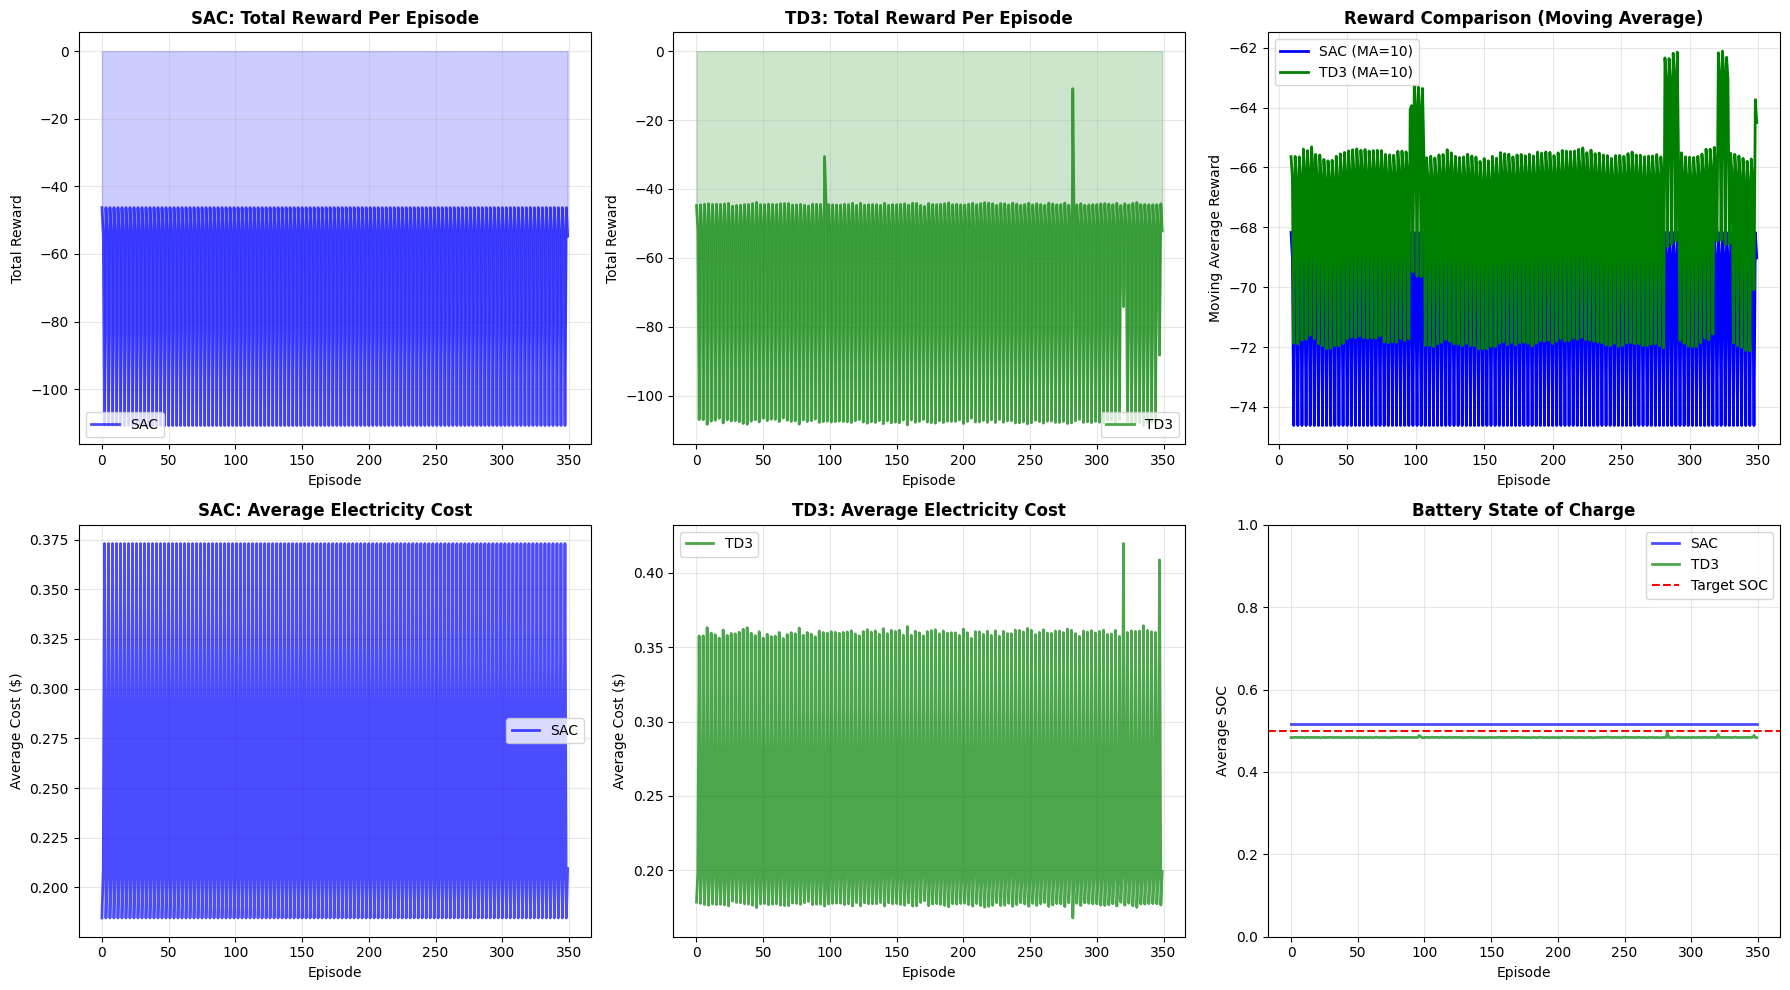

📊 COURBES SAUVEGARDÉES
Location: /workspaces/energy-rl-project/results/figures/phase_3c_training_curves.png


In [8]:
# ============================================================================
# CELL 6 : VISUALISER LES COURBES DE CONVERGENCE
# ============================================================================

%matplotlib inline

print("\n" + "=" * 80)
print("📊 PHASE 3C : VISUALISATION DES COURBES DE CONVERGENCE")
print("=" * 80 + "\n")

# ⭐ CRÉER FIGURE (2x3 = 6 subplots)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# ============================================================================
# ROW 1 : REWARDS
# ============================================================================

# 1. SAC Reward
axes[0, 0].plot(sac_history['total_reward'], label='SAC', color='blue', linewidth=2, alpha=0.7)
axes[0, 0].fill_between(range(len(sac_history['total_reward'])), 
                         sac_history['total_reward'], 
                         alpha=0.2, color='blue')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].set_title('SAC: Total Reward Per Episode', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. TD3 Reward
axes[0, 1].plot(td3_history['total_reward'], label='TD3', color='green', linewidth=2, alpha=0.7)
axes[0, 1].fill_between(range(len(td3_history['total_reward'])), 
                         td3_history['total_reward'], 
                         alpha=0.2, color='green')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Total Reward')
axes[0, 1].set_title('TD3: Total Reward Per Episode', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Reward Comparison (moving average)
sac_reward_ma = pd.Series(sac_history['total_reward']).rolling(window=10).mean()
td3_reward_ma = pd.Series(td3_history['total_reward']).rolling(window=10).mean()

axes[0, 2].plot(sac_reward_ma, label='SAC (MA=10)', color='blue', linewidth=2)
axes[0, 2].plot(td3_reward_ma, label='TD3 (MA=10)', color='green', linewidth=2)
axes[0, 2].set_xlabel('Episode')
axes[0, 2].set_ylabel('Moving Average Reward')
axes[0, 2].set_title('Reward Comparison (Moving Average)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend()

# ============================================================================
# ROW 2 : COST ET LOSS
# ============================================================================

# 4. Average Cost per Episode
axes[1, 0].plot(sac_history['avg_cost'], label='SAC', color='blue', linewidth=2, alpha=0.7)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Average Cost ($)')
axes[1, 0].set_title('SAC: Average Electricity Cost', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 5. TD3 Average Cost
axes[1, 1].plot(td3_history['avg_cost'], label='TD3', color='green', linewidth=2, alpha=0.7)
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Average Cost ($)')
axes[1, 1].set_title('TD3: Average Electricity Cost', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

# 6. Average SOC
axes[1, 2].plot(sac_history['avg_soc'], label='SAC', color='blue', linewidth=2, alpha=0.7)
axes[1, 2].plot(td3_history['avg_soc'], label='TD3', color='green', linewidth=2, alpha=0.7)
axes[1, 2].axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, label='Target SOC')
axes[1, 2].set_xlabel('Episode')
axes[1, 2].set_ylabel('Average SOC')
axes[1, 2].set_title('Battery State of Charge', fontsize=12, fontweight='bold')
axes[1, 2].set_ylim([0.0, 1.0])
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].legend()

plt.tight_layout()
plt.savefig(RESULTS_FIGURES_DIR / 'phase_3c_training_curves.png', dpi=150, bbox_inches='tight')
print(f"✅ Figure saved: phase_3c_training_curves.png\n")
plt.show()

print("=" * 80)
print("📊 COURBES SAUVEGARDÉES")
print("=" * 80)
print(f"Location: {RESULTS_FIGURES_DIR / 'phase_3c_training_curves.png'}")

In [9]:
# ============================================================================
# CELL 7 : TABLEAU RÉCAPITULATIF SAC vs TD3
# ============================================================================

print("\n" + "=" * 80)
print("📋 TABLEAU RÉCAPITULATIF : SAC vs TD3")
print("=" * 80 + "\n")

# ⭐ CALCULER LES STATS
summary_data = {
    'Agent': ['SAC', 'TD3'],
    'Avg Reward': [
        np.mean(sac_history['total_reward']),
        np.mean(td3_history['total_reward']),
    ],
    'Max Reward': [
        np.max(sac_history['total_reward']),
        np.max(td3_history['total_reward']),
    ],
    'Min Reward': [
        np.min(sac_history['total_reward']),
        np.min(td3_history['total_reward']),
    ],
    'Std Reward': [
        np.std(sac_history['total_reward']),
        np.std(td3_history['total_reward']),
    ],
    'Avg Cost ($)': [
        np.mean(sac_history['avg_cost']),
        np.mean(td3_history['avg_cost']),
    ],
    'Avg SOC': [
        np.mean(sac_history['avg_soc']),
        np.mean(td3_history['avg_soc']),
    ],
}

df_summary = pd.DataFrame(summary_data)

# ⭐ AFFICHER TABLEAU
print(df_summary.to_string(index=False))

# ⭐ ANALYSE
print("\n" + "=" * 80)
print("🔍 ANALYSE")
print("=" * 80)

sac_avg = np.mean(sac_history['total_reward'])
td3_avg = np.mean(td3_history['total_reward'])

if sac_avg > td3_avg:
    print(f"✅ SAC performs better: +{sac_avg - td3_avg:.2f} reward")
elif td3_avg > sac_avg:
    print(f"✅ TD3 performs better: +{td3_avg - sac_avg:.2f} reward")
else:
    print(f"😐 Performance is similar")

print(f"\nCost efficiency:")
sac_cost = np.mean(sac_history['avg_cost'])
td3_cost = np.mean(td3_history['avg_cost'])
print(f"  SAC: ${sac_cost:.2f}/episode")
print(f"  TD3: ${td3_cost:.2f}/episode")

print(f"\nBattery management (target: 0.5 SOC):")
sac_soc = np.mean(sac_history['avg_soc'])
td3_soc = np.mean(td3_history['avg_soc'])
print(f"  SAC: {sac_soc:.3f} (error: {abs(sac_soc - 0.5):.3f})")
print(f"  TD3: {td3_soc:.3f} (error: {abs(td3_soc - 0.5):.3f})")

print("\n" + "=" * 80)
print("✅ PHASE 3C TERMINÉE")
print("=" * 80)

# ⭐ SAUVEGARDER LE TABLEAU
csv_path = RESULTS_FIGURES_DIR.parent / 'phase_3c_summary.csv'
df_summary.to_csv(csv_path, index=False)
print(f"Summary saved to: {csv_path}")


📋 TABLEAU RÉCAPITULATIF : SAC vs TD3



Agent  Avg Reward  Max Reward  Min Reward  Std Reward  Avg Cost ($)  Avg SOC
  SAC  -70.488892  -46.307602 -110.749649   28.556261      0.255355 0.515679
  TD3  -67.485962  -10.905050 -108.592514   28.142153      0.244847 0.483824

🔍 ANALYSE
✅ TD3 performs better: +3.00 reward

Cost efficiency:
  SAC: $0.26/episode
  TD3: $0.24/episode

Battery management (target: 0.5 SOC):
  SAC: 0.516 (error: 0.016)
  TD3: 0.484 (error: 0.016)

✅ PHASE 3C TERMINÉE
Summary saved to: /workspaces/energy-rl-project/results/phase_3c_summary.csv
